# EchoCare: Cry Detection Model Training
## Stage 1 of Two-Stage Pipeline

This notebook trains a binary classification model to detect infant cries vs non-cry sounds.

**Dataset:**
- Cry sounds: Baby Chillanto Database (normal, hungry, pain)
- Non-cry sounds: ESC-50 Dataset

**Target Performance:** >85% accuracy for cry detection

**Architecture:** MobileNetV2 (lightweight for Raspberry Pi deployment) with custom classification head

## 1. Import Libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import cv2
import json
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.12.0


## 2. Configuration

In [20]:
# Paths
train_dir = Path("C:/Users/danel/FYP/echocare-infant-cry-classification/dataset/processed/mel-spectrograms/cry_detection/train")
val_dir = Path("C:/Users/danel/FYP/echocare-infant-cry-classification/dataset/processed/mel-spectrograms/cry_detection/validate")
test_dir = Path("C:/Users/danel/FYP/echocare-infant-cry-classification/dataset/processed/mel-spectrograms/cry_detection/test")
save_dir = Path("C:/Users/danel/FYP/echocare-infant-cry-classification/model/cry_detection")

# Model hyperparameters
img_size = (224, 224)  # MobileNetV2 input size
batch_size = 32
epochs = 30
learning_rate = 0.0001
dropout_rate = 0.4 

# Class information
class_names = ['non-cry', 'cry']
num_classes = 2

## 3. Data Loading Functions

In [22]:
def load_spectrograms(data_dir, verbose=True):
    """
    Load .npy spectrograms from directory structure.

    Args:
        data_dir: Path object or string path to directory containing cry/non_cry folders
        verbose: Print loading progress
    
    Returns:
        spectrograms: numpy array of spectrograms
        labels: numpy array of labels (0=non-cry, 1=cry)
    """

    spectrograms = []
    labels = []
    
    # Load cry mel-spectrograms (label = 1)
    cry_dir = data_dir / 'cry'  # Find the 'cry' subfolder
    cry_files = list(cry_dir.glob('*.npy')) # Get all .npy files in the 'cry' folder
    
    for file in cry_files: # Load each cry file and label it as 1 (cry = 1, non-cry = 0)
        spec = np.load(file) # load the .npy (mel spectrogram) file
        spectrograms.append(spec) # add to mel-spectrograms list
        labels.append(1) # label as cry (1)
    
    if verbose:
        print(f"Loaded {len(cry_files)} cry spectrograms")
    
    # Load non-cry spectrograms (label = 0)
    non_cry_dir = data_dir / 'non-cry'
    non_cry_files = list(non_cry_dir.glob('*.npy'))
    
    for file in non_cry_files:
        spec = np.load(file)
        spectrograms.append(spec)
        labels.append(0)
    
    if verbose:
        print(f"Loaded {len(non_cry_files)} non-cry spectrograms")
        print(f"Total samples: {len(spectrograms)}")
    
    return np.array(spectrograms), np.array(labels)

## 4. Prepare Mel-Spectrograms for MobileNetV2 Architecture

In [23]:
def prepare_for_mobilenet(spectrograms, target_size=(224, 224)):
    """
    Prepare mel-spectrograms for MobileNetV2 input.
    
    Transforms all mel-spectrograms from (128, 32) grayscale format to (224, 224, 3) RGB format required by MobileNetV2's pre-trained weights from ImageNet.
    
    Process:
    1. Input: (128, 32) - 128 mel bands x 32 time frames
    2. Add channel: (128, 32, 1) - add dimension for grayscale
    3. Resize: (224, 224, 1) - match MobileNetV2 input size
    4. Repeat channels: (224, 224, 3) - convert to RGB by duplicating grayscale values
    
    Args:
        spectrograms: numpy array of mel-spectrograms with shape (n_samples, 128, 32)
        target_size: tuple (height, width) for resizing, default (224, 224)
    
    Returns:
        prepared: numpy array with shape (n_samples, 224, 224, 3)
    """
    prepared = []
    
    for spec in spectrograms:
        # Step 1: Add channel dimension
        # Transform from (128, 32) to (128, 32, 1)
        # This prepares the 2D mel-spectrogram for image processing
        if len(spec.shape) == 2:
            spec = np.expand_dims(spec, axis=-1)  # Expand the shape of the array. Shape: (128, 32, 1)
        
        # Step 2: Resize to MobileNetV2's expected input size
        # Transform from (128, 32, 1) to (224, 224, 1)
        # Width stretches from 32 → 224 frames (7x expansion)
        # Height expands from 128 → 224 mel bands (~1.75x expansion)
        resized = cv2.resize(spec, target_size)  # Expand the shape of the array. Shape: (224, 224, 1)
        
        # Step 3: Ensure channel dimension exists after resize
        if len(resized.shape) == 2:
            resized = np.expand_dims(resized, axis=-1)  # Shape: (224, 224, 1)
        
        # Step 4: Convert grayscale (1 channel) to RGB (3 channels)
        # Transform from (224, 224, 1) to (224, 224, 3)
        # Creates "fake RGB" by duplicating the same values across R, G, B channels
        # This allows MobileNetV2 (trained on colour images) to process the grayscale spectrograms
        if resized.shape[-1] == 1:
            resized = np.repeat(resized, 3, axis=-1)  # Final shape: (224, 224, 3)
        
        prepared.append(resized) # add to prepared list
    
    return np.array(prepared, dtype=np.float32)

## 5. Load and Visualise Cry Detection (Cry vs Non-cry) Data

In [24]:
# Load training data
print("Loading training data...")
X_train_raw, y_train = load_spectrograms(train_dir)

# Load validation data
print("\nLoading validation data...")
X_val_raw, y_val = load_spectrograms(val_dir)

# Load test data
print("\nLoading test data...")
X_test_raw, y_test = load_spectrograms(test_dir)

print(f"Training samples: {len(X_train_raw)}")
print(f"Validation samples: {len(X_val_raw)}")
print(f"Test samples: {len(X_test_raw)}")
print(f"Raw spectrogram shape: {X_train_raw[0].shape}")

Loading training data...
Loaded 734 cry spectrograms
Loaded 1400 non-cry spectrograms
Total samples: 2134

Loading validation data...
Loaded 157 cry spectrograms
Loaded 300 non-cry spectrograms
Total samples: 457

Loading test data...
Loaded 158 cry spectrograms
Loaded 300 non-cry spectrograms
Total samples: 458
Training samples: 2134
Validation samples: 457
Test samples: 458
Raw spectrogram shape: (128, 32)


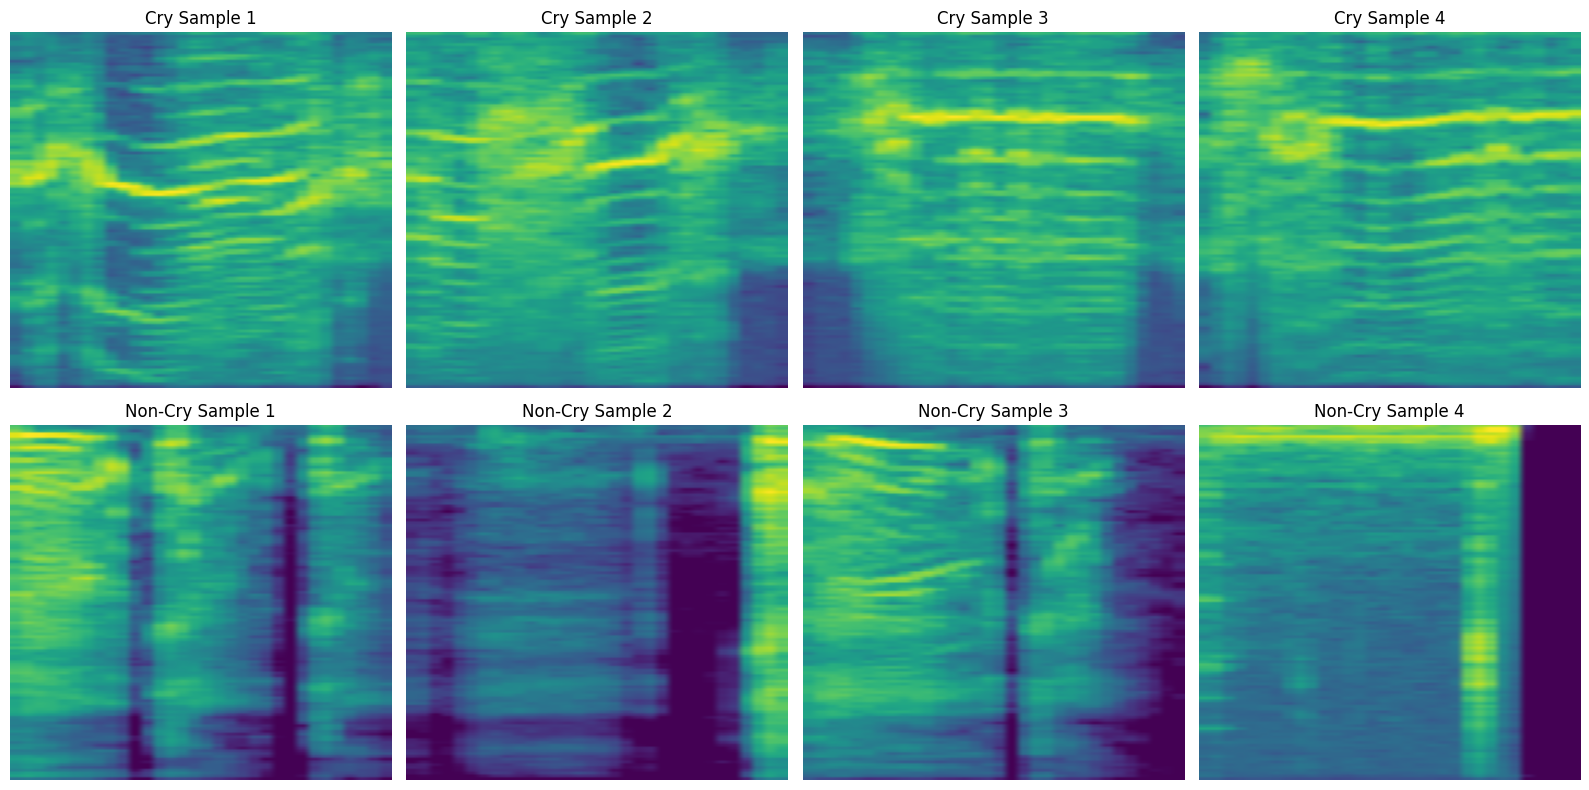

In [32]:
# Visualise sample spectrograms
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Find 4 cry samples (where label = 1)
cry_indices = np.where(y_train == 1)[0][20:24]

# Find 4 non-cry samples (where label = 0)  
non_cry_indices = np.where(y_train == 0)[0][20:24]

# Plot 4 cry samples in top row
for i in range(4):
    spec = X_train_raw[cry_indices[i]]  # Get cry mel-spectrogram (128 mel bands × 32 time frames)
    axes[0, i].imshow(spec, aspect='auto')
    axes[0, i].set_title(f'Cry Sample {i+1}')
    axes[0, i].axis('off')

# Plot 4 non-cry samples in bottom row
for i in range(4):
    spec = X_train_raw[non_cry_indices[i]]  # Get non-cry mel-spectrogram (128 mel bands × 32 time frames)
    axes[1, i].imshow(spec, aspect='auto')
    axes[1, i].set_title(f'Non-Cry Sample {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 6. Normalising Mel-Spectrograms

In [42]:
# Calculate normalisation parameters from training set only
mean = np.mean(X_train_raw)
std = np.std(X_train_raw)

print(f"Training set statistics:")
print(f"Mean: {mean:.2f}")
print(f"Std:  {std:.2f}")
print(f"Min:  {np.min(X_train_raw):.2f}")
print(f"Max:  {np.max(X_train_raw):.2f}")

# Apply standardisation (z-score normalisation)
X_train_norm = (X_train_raw - mean) / std
X_val_norm = (X_val_raw - mean) / std
X_test_norm = (X_test_raw - mean) / std

print("\nAfter normalisation:")
print(f"Training mean: {np.mean(X_train_norm):.2f} ") # (should be ~0)
print(f"Training std:  {np.std(X_train_norm):.2f} ") # (should be ~1)

# Show normalisation parameters for deployment on Raspberry Pi
normalisation_params = {
    "mean": float(mean),
    "std": float(std),
    "method": "standardisation"
}

print(normalisation_params)

Training set statistics:
Mean: -37.63
Std:  22.11
Min:  -80.00
Max:  0.00

After normalisation:
Training mean: 0.00 
Training std:  1.00 
{'mean': -37.628456115722656, 'std': 22.107717514038086, 'method': 'standardisation'}


## 7. Prepare Data for MobileNetV2

In [43]:
# Resize and convert to 3-channel format
print("Preparing data for MobileNetV2")

X_train = prepare_for_mobilenet(X_train_norm, target_size=img_size) # prepare training set
X_val = prepare_for_mobilenet(X_val_norm, target_size=img_size) # prepare validation set
X_test = prepare_for_mobilenet(X_test_norm, target_size=img_size) # prepare test set

print(f"\nFinal shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"\n  y_train: {y_train.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  y_test:  {y_test.shape}")

Preparing data for MobileNetV2

Final shapes:
  X_train: (2134, 224, 224, 3)
  X_val:   (457, 224, 224, 3)
  X_test:  (458, 224, 224, 3)

  y_train: (2134,)
  y_val:   (457,)
  y_test:  (458,)


## 8. Calculate Class Weights

In [44]:
# Compute class weights to handle imbalance
# Training set has: 734 cry sounds, 1400 non-cry sounds

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights to handle imbalance:")
for cls, weight in class_weights.items():
    print(f"{class_names[cls]}: {weight:.4f}")

print("\nThis gives more importance to the minority class (cry) during training.")

Class weights to handle imbalance:
non-cry: 0.7621
cry: 1.4537

This gives more importance to the minority class (cry) during training.


## 9. Build Cry Detection Model

In [ ]:
def build_cry_detection_model(input_shape=(224, 224, 3), dropout_rate=0.4):
    """
    Build MobileNetV2-based binary classifier for cry detection.
    
    Args:
        input_shape: Input image shape
        dropout_rate: Dropout rate for preventing overfitting
    
    Returns:
        model: Compiled Keras model
    """
    # Load MobileNetV2 (without top classification layer)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False, # Exclude final classification layer
        weights='imagenet'
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(dropout_rate, name='dropout')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)  # Binary classification
    
    # Create model
    model = Model(inputs=base_model.input, outputs=output, name='CryDetectionModel')
    
    return model